In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

base_dir = "/".join(os.getcwd().split("/")[:-1])

In [13]:
def read_experiment(base_dir, acquisition, objective, seed, suffix):
    
    file = f"{base_dir}/experiments/{acquisition}/{objective}/seed-{seed}{suffix}/log-regret.txt"
    df = pd.read_csv(file, sep=', ', header=None, engine="python")
    
    num_bo_steps = df[0].values
    num_points = df[1].values
    log10_regret = df[2].values
    
    return num_bo_steps, num_points, log10_regret

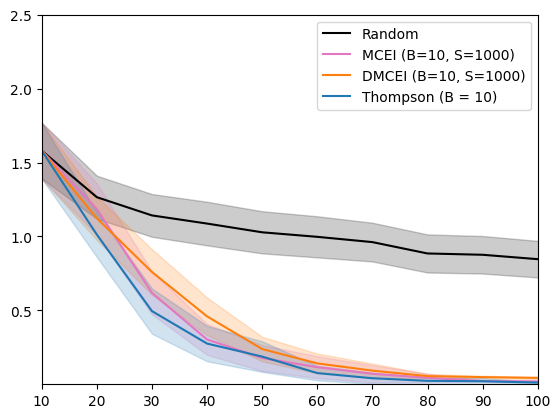

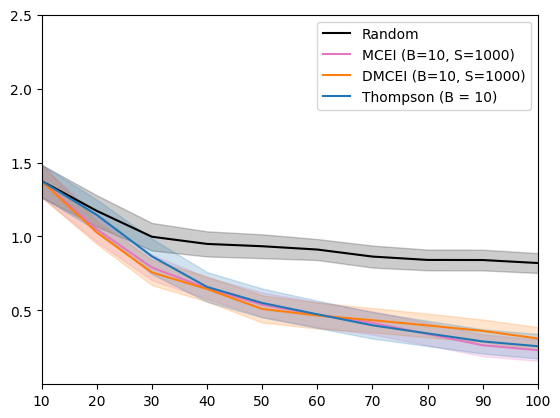

In [15]:
seeds = list(range(40))
B = 10
S = 1000

acquisitions = [
    [("random", "_batch_size-10"), "Random", "black"],
    # [("ei", ""), "EI (B=1, exact)", "tab:purple"],
    [("mcei", f"_batch_size-{B}_num_mcei_samples-{S}"), f"MCEI (B={B}, S={S})", "tab:pink"],
    [("dmcei", f"_batch_size-{B}_num_mcei_samples-{S}"), f"DMCEI (B={B}, S={S})", "tab:orange"],
    # [("amcei", f"_batch_size-20_num_mcei_samples-{S}"), f"AMCEI (B=20, S={S}, beta=0.1)", "tab:cyan"],
    [("thompson", f"_batch_size-{B}"), f"Thompson (B = {B})", "tab:blue"],
]

objectives = [
    "matern52_4_0",
    "matern52_4_1",
    # "matern52_4_2",
]

for objective in objectives:

    results = {}

    for (acquisition, suffix), _, _ in acquisitions:

        regret = []
        results[acquisition + suffix] = {}

        for seed in seeds:

            num_bo_steps, num_points, log10_regret = read_experiment(
                base_dir=base_dir,
                acquisition=acquisition,
                objective=objective,
                seed=seed,
                suffix=suffix,
            )

            regret.append(10**log10_regret)

        results[acquisition + suffix]["num_bo_steps"] = num_bo_steps
        results[acquisition + suffix]["num_points"] = num_points
        results[acquisition + suffix]["regret"] = np.stack(regret, axis=0)
        results[acquisition + suffix]["mean_regret"] = np.mean(regret, axis=0)
        results[acquisition + suffix]["median_regret"] = np.median(regret, axis=0)
        results[acquisition + suffix]["stddev_regret"] = np.var(regret, axis=0)**0.5
        results[acquisition + suffix]["uq_regret"] = np.quantile(regret, 0.975, axis=0)
        results[acquisition + suffix]["lq_regret"] = np.quantile(regret, 0.025, axis=0)


    for ((acquisition, suffix), name, color) in acquisitions:

        regret = results[acquisition + suffix]["regret"].T
        mean_regret = results[acquisition + suffix]["mean_regret"].T
        median_regret = results[acquisition + suffix]["median_regret"]
        num_points = results[acquisition + suffix]["num_points"]
        num_bo_steps = results[acquisition + suffix]["num_bo_steps"]
        uq_regret = results[acquisition + suffix]["uq_regret"]
        lq_regret = results[acquisition + suffix]["lq_regret"]
        stddev_regret = results[acquisition + suffix]["stddev_regret"]

        plt.plot(
            num_points,
            mean_regret,
            color=color,
            label=name,
        )

        plt.fill_between(
            num_points,
            mean_regret-2.*stddev_regret/len(seeds)**0.5,
            mean_regret+2.*stddev_regret/len(seeds)**0.5,
            alpha=0.2,
            color=color,
        )

    plt.xlim([10, 100])
    plt.ylim([0.00001, 2.5])
    plt.legend()
    plt.show()